In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed = 42

In [2]:
x0 = 20
t0 = 0
T = 0.5

sigma_x = 0.03

In [3]:
def x(x, v):
    return x + T*v + np.random.normal(0, sigma_x * T)

In [4]:
t = t0 + T
v = -1

xarr = [x0]
tarr = [t0]

while t <= 100:
    x_val = x(xarr[-1], v)
    
    xarr.append(x_val)
    tarr.append(t)
    
    if x_val <= 0:
        v = 1
        xarr[-1] = np.abs(xarr[-1])
        
    t += T
    
xarr = np.array(xarr)
tarr = np.array(tarr)

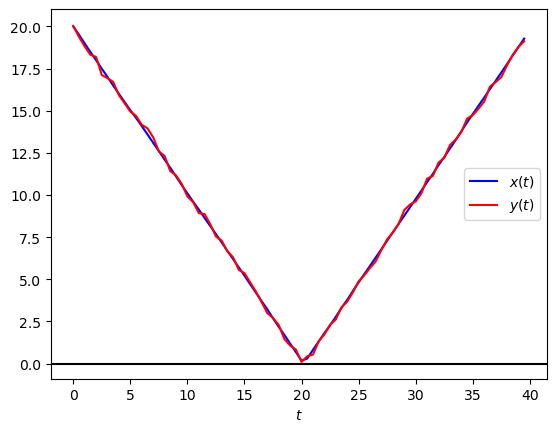

In [5]:
sigma_y = 0.15

yarr = xarr + np.random.normal(0, sigma_y, size = xarr.shape[0])

cnt = 80

plt.plot(tarr[:cnt], xarr[:cnt], label=r'$x(t)$', color='b')
plt.plot(tarr[:cnt], yarr[:cnt], label=r'$y(t)$', color='r')
plt.axhline(0, color='black')

plt.legend()
plt.xlabel(r'$t$')
plt.show()

### Kalman Filter

In [6]:
def kalman_filter(x0, P0, A, C, Q, R, yarr):

    x = x0.copy()
    P = P0.copy()

    xarr = [x0]

    for y in yarr:
        x_est = A @ x
        P_est = A @ P @ A.T + Q
        
        y_est = C @ x_est
        dy = y - y_est
        
        S = C @ P_est @ C.T + R
        F = P_est @ C.T @ np.linalg.inv(S)
        
        x = x_est + F @ dy
        P = (np.eye(A.shape[0]) - F @ C) @ P_est
        
        xarr.append(x)
        
    xarr = np.array(xarr).squeeze()
    return xarr

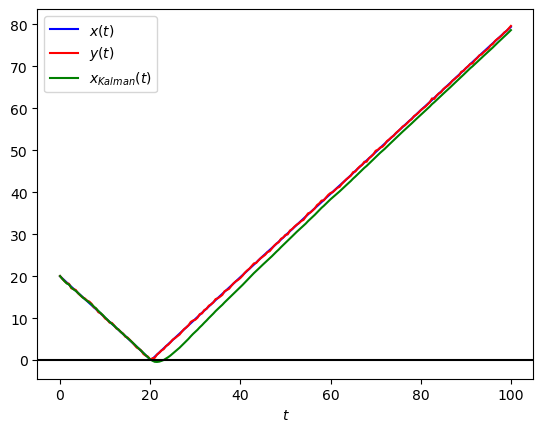

In [7]:
state0 = np.array([[x0], [0]]).reshape(-1, 1)
P0 = np.eye(state0.shape[0]) * 100

A = np.array([
    [1, T],
    [0, 1],
])

C = np.array([[1, 0]])

Q = np.array([
    [sigma_x**2, 0],
    [0, 0],
])

R = np.array([[sigma_y**2]])

kalman = kalman_filter(state0, P0, A, C, Q, R, yarr)

plt.plot(tarr, xarr, label=r'$x(t)$', color='b')
plt.plot(tarr, yarr, label=r'$y(t)$', color='r')
plt.plot(tarr, kalman[1:, 0], label=r'$x_{Kalman}(t)$', color='g')
plt.axhline(0, color='black')

plt.legend()
plt.xlabel(r'$t$')
plt.show()

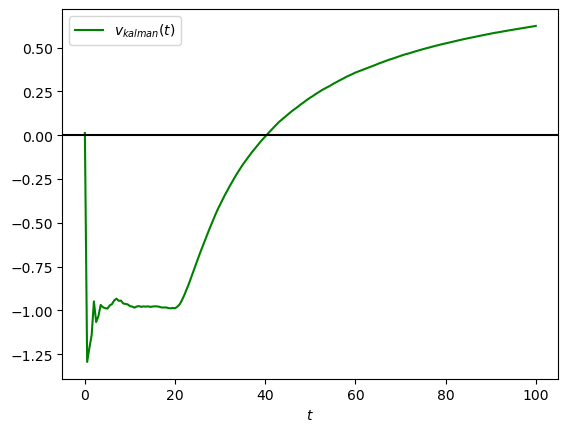

In [8]:
plt.plot(tarr, kalman[1:, 1], label=r'$v_{kalman}(t)$', color='g')
plt.axhline(0, color='black')

plt.legend()
plt.xlabel(r'$t$')
plt.show()

### Particle Filter

In [ ]:
def normal_distribution(x, mean, std):
    return 1/std/np.sqrt(2*np.pi) * np.exp(-(x - mean)**2 / 2 / std**2)

In [ ]:
def initialize_particles(num_particles, x_mean, x_std, v_mean, v_std):
    particles = []
    
    for _ in range(num_particles):
        particle = dict()
        
        particle['x'] = np.random.normal(x_mean, x_std)
        particle['v'] = np.random.normal(v_mean, v_std)
        particles.append(particle)
    
    return particles

In [ ]:
def sample_motion_model(particles):
    new_particles = []
    
    for p in particles:
        x_n = x(p['x'], p['v'])
        v_n = p['v']
        
        if x_n <= 0 and p['x'] > 0:
            x_n = -x_n
            v_n = -v_n
        
        new_particles.append({'x': x_n, 'v': v_n})
        
    return new_particles

In [ ]:
def eval_sensor_model(y_val, particles):
    weights = []

    for p in particles:
        likelihood = normal_distribution(p['x'], y_val, sigma_y)
        weights.append(likelihood)

    normalizer = sum(weights)
    weights = weights / normalizer

    return weights

In [ ]:
def resample_particles(particles, weights):

    new_particles = []

    step = 1 / len(weights)
    r = np.random.uniform(0, step)

    uarr = [r + i * step for i in range(len(weights))]

    sum = 0
    i = 0

    for u in uarr:
        while u > sum:
           sum += weights[i]
           i += 1
        new_particles.append(particles[i-1])

    return new_particles

In [ ]:
def mean_pose(particles):
    xs = []
    vs = []

    for particle in particles:
        xs.append(particle['x'])
        vs.append(particle['v'])

    mean_x = np.mean(xs)
    mean_v = np.mean(vs)

    return [mean_x, mean_v]

In [ ]:
particles = initialize_particles(1000, 20, 0.5, -1, 0.5)

mean_arr = [mean_pose(particles)]

for t_val, y_val in zip(tarr, yarr):
    new_particles = sample_motion_model(particles)

    weights = eval_sensor_model(y_val, new_particles)

    particles = resample_particles(new_particles, weights)
    
    mean_arr.append(mean_pose(particles))
    
    # p = []
    # for k in new_particles:
    #     p.append((k['x'], k['v']))
    # p = np.array(p)
    # plt.scatter(p[:, 0], p[:, 1])
    # plt.show()
    
mean_arr = np.array(mean_arr)

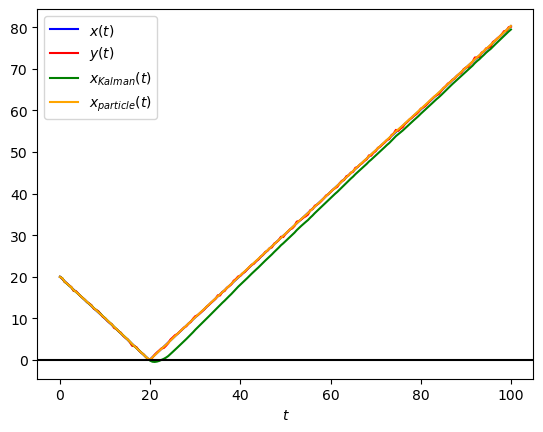

In [ ]:
plt.plot(tarr, xarr, label=r'$x(t)$', color='b')
plt.plot(tarr, yarr, label=r'$y(t)$', color='r')
plt.plot(tarr, kalman[1:, 0], label=r'$x_{Kalman}(t)$', color='g')
plt.plot(tarr, mean_arr[1:, 0], label=r'$x_{particle}(t)$', color='orange')
plt.axhline(0, color='black')

plt.legend()
plt.xlabel(r'$t$')
plt.show()